In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates
from sklearn.decomposition import PCA



In [28]:
repo_embs_path = 'repo_embs.feather'
fs_bs_path = 'fs_bs.feather'

df_repo_embs = pd.read_feather(repo_embs_path)
df_fs_bs = pd.read_feather(fs_bs_path)

df_merged = pd.merge(df_repo_embs, df_fs_bs, on='repo_url', how='inner')

df_merged['date'] = pd.to_datetime(df_merged['date']).dt.to_period('M')

group_mapping = {
    'Google': 'Group 1', 'Amazon': 'Group 1', 'Facebook': 'Group 1', 'Apple': 'Group 1', 'Microsoft': 'Group 1',
    'IBM': 'Group 2', 'Tencent': 'Group 2', 'Intel': 'Group 2', 'Samsung': 'Group 2', 'Alibaba': 'Group 2',
    'OpenAI': 'Group 3', 'NVIDIA': 'Group 3', 'Huawei': 'Group 3', 'Salesforce': 'Group 3', 'Baidu': 'Group 3',
}
df_merged['company_group'] = df_merged['repo_url'].apply(lambda x: next((grp for key, grp in group_mapping.items() if key.lower() in x.lower()), 'Group 4'))

df_filtered = df_merged

grouped = df_merged.groupby(['company_group', 'date'])['embedding'].apply(lambda x: np.mean(np.vstack(x), axis=0))

df_filtered['date'] = df_filtered['date'].astype(str)

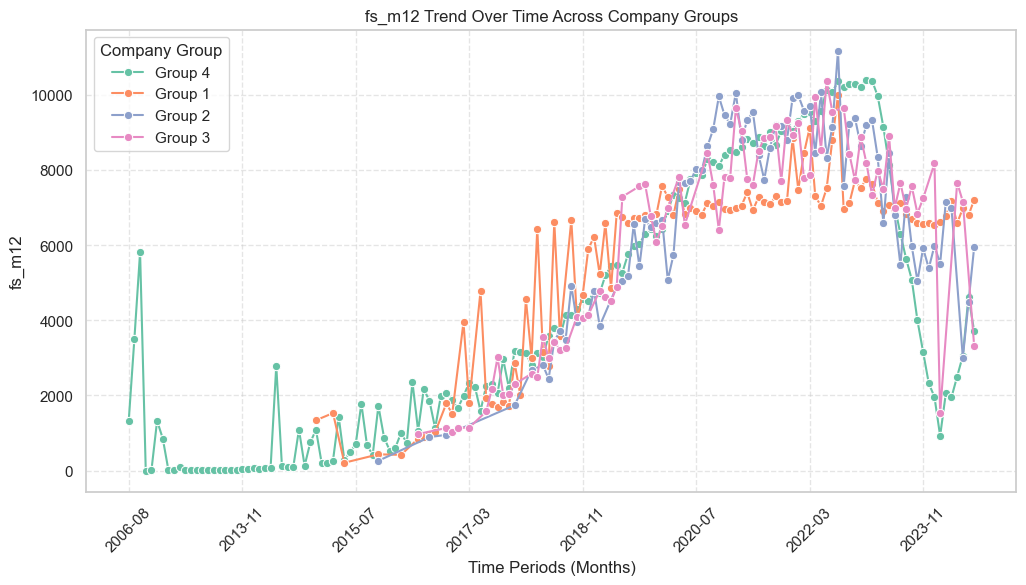

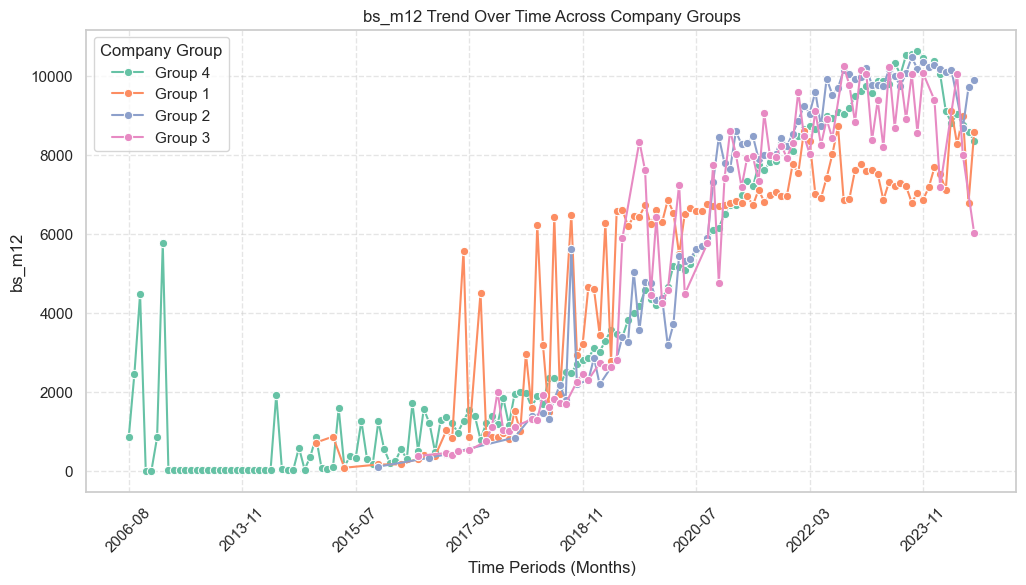

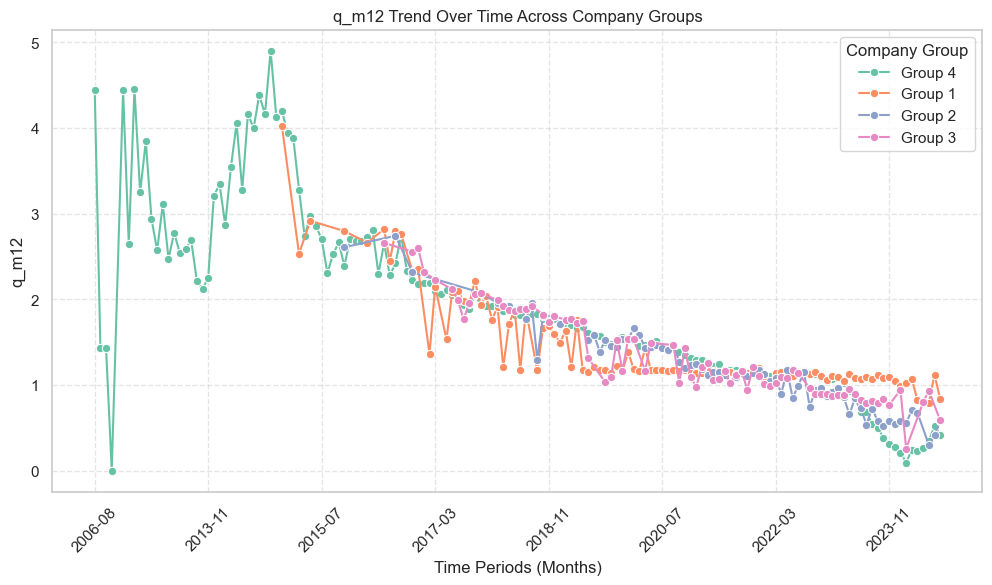

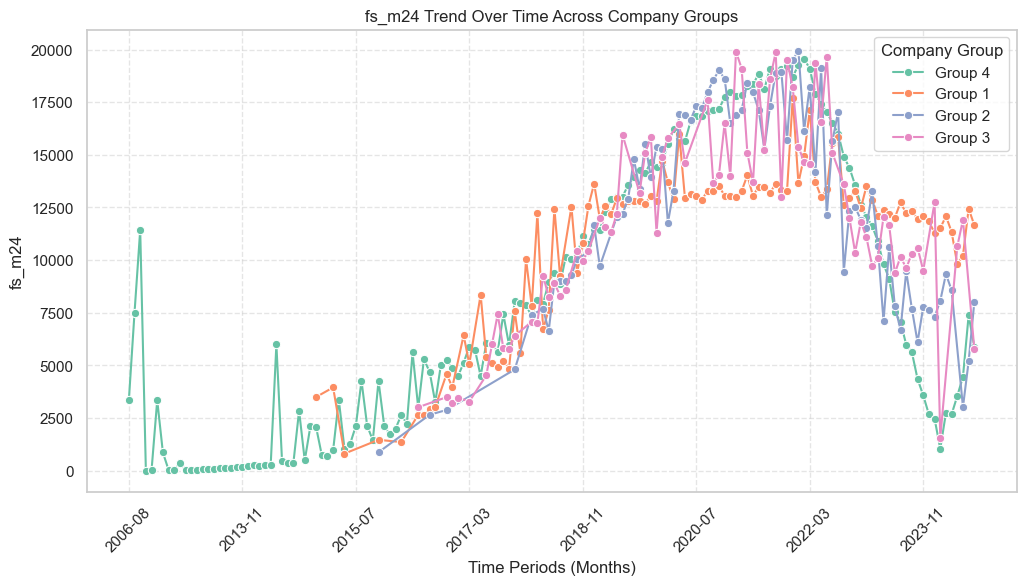

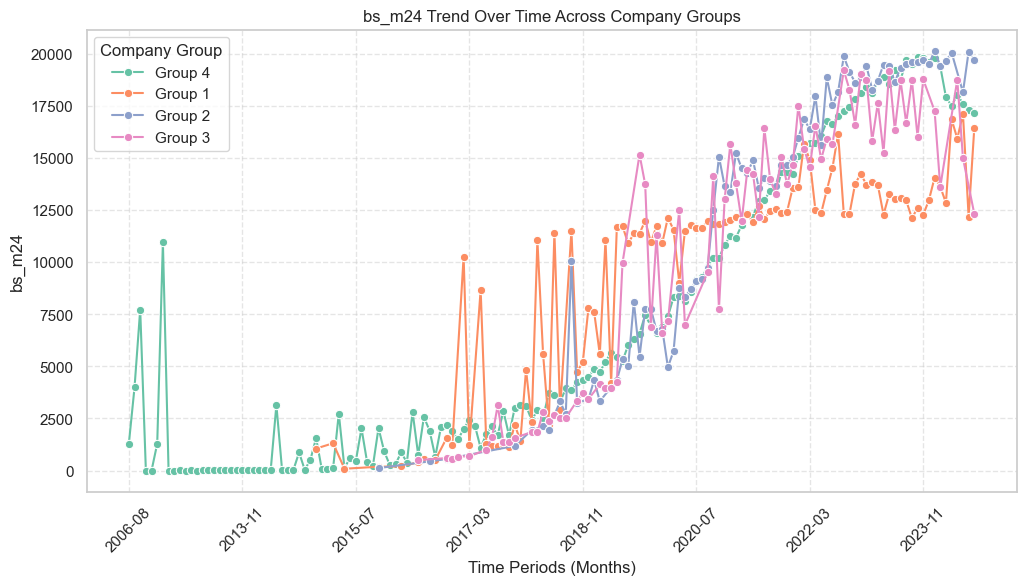

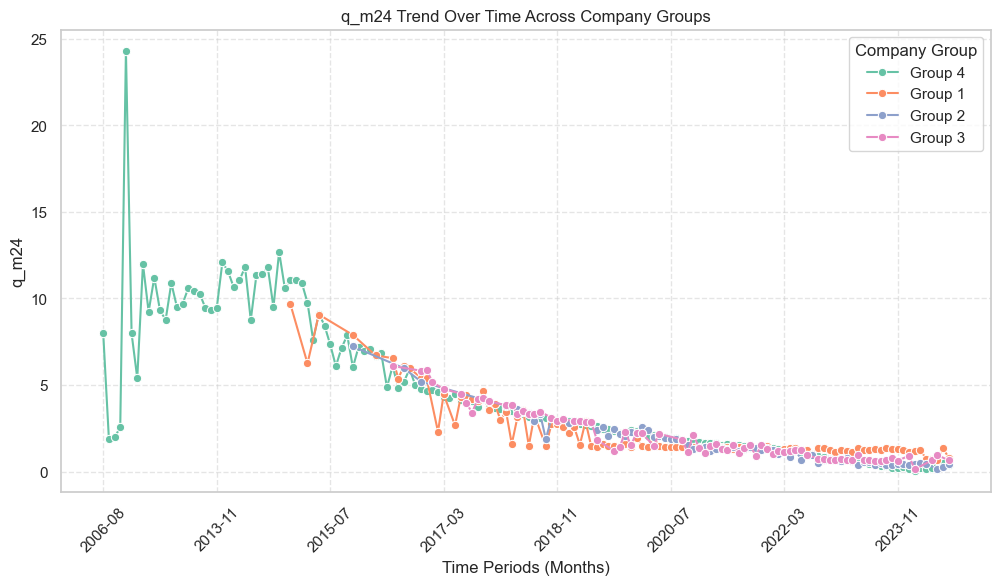

In [29]:
metrics = ['fs_m12', 'bs_m12', 'q_m12', 'fs_m24', 'bs_m24', 'q_m24']

sns.set(style="whitegrid")
for metric in metrics:
    plt.figure(figsize=(12, 6))
    
    grouped_metric = df_filtered.groupby(['company_group', 'date'])[metric].mean().reset_index()
    grouped_metric = grouped_metric.sort_values(by='date')
    
    sns.lineplot(data=grouped_metric, x='date', y=metric, hue='company_group', marker='o', palette="Set2")
    
    plt.title(f'{metric} Trend Over Time Across Company Groups')
    plt.xlabel('Time Periods (Months)')
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=10))
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(title='Company Group')
    
    plt.show()

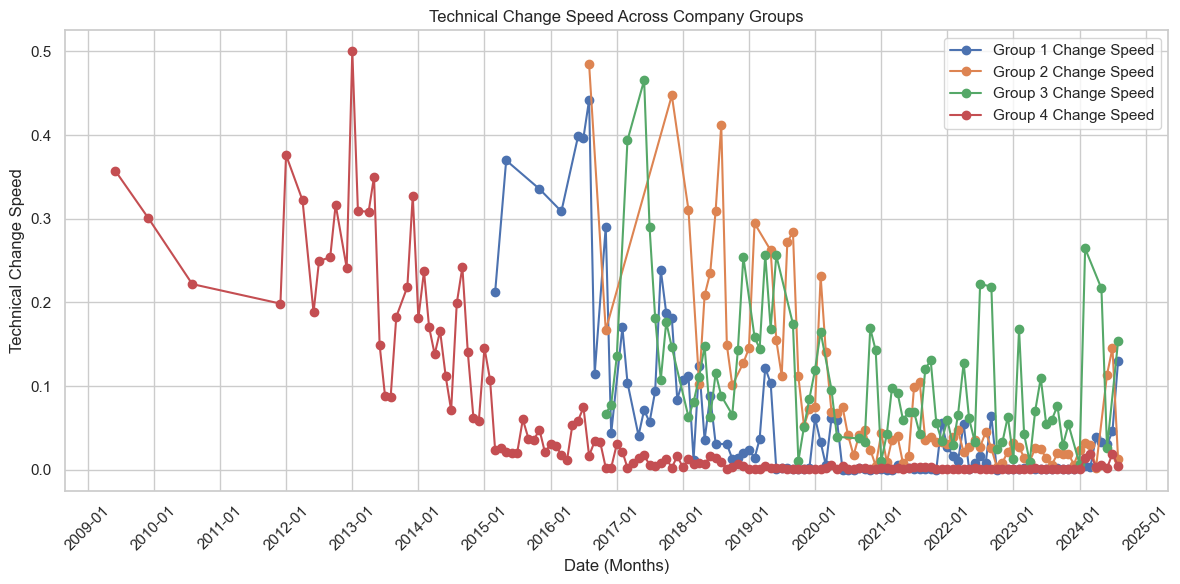

In [43]:
def calculate_change_speed(vectors):
    cos_similarities = [cosine_similarity([vectors[i]], [vectors[i+1]])[0][0] for i in range(len(vectors) - 1)]
    change_speeds = [1 - sim for sim in cos_similarities]
    return change_speeds

change_speeds = {}
dates_dict = {}
for group, data in grouped.groupby(level=0):
    embeddings_over_time = data.values
    change_speeds[group] = calculate_change_speed(embeddings_over_time)
    dates = grouped[group].index.get_level_values('date')[1:]
    dates_dict[group] = pd.to_datetime(dates.astype(str), format="%Y-%m")

plt.figure(figsize=(12, 6))
for group, speeds in change_speeds.items():
    dates = dates_dict[group]
    plt.plot(dates, speeds, label=f'{group} Change Speed', marker='o')

plt.xlabel('Date (Months)')
plt.ylabel('Technical Change Speed')
plt.title('Technical Change Speed Across Company Groups')

plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

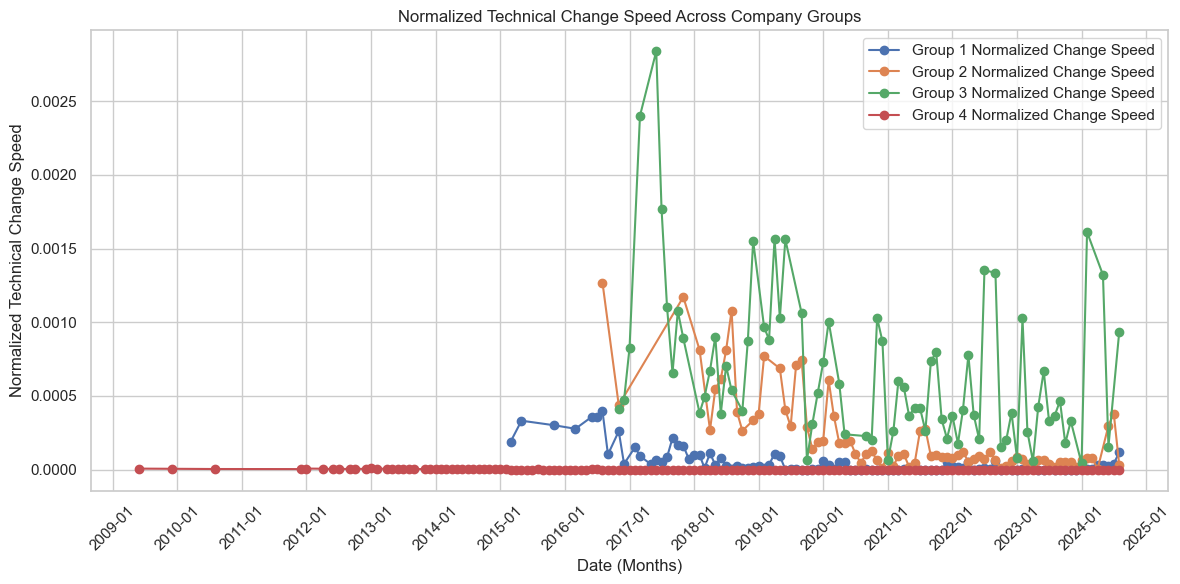

In [44]:
def calculate_change_speed(vectors):
    cos_similarities = [cosine_similarity([vectors[i]], [vectors[i+1]])[0][0] for i in range(len(vectors) - 1)]
    change_speeds = [1 - sim for sim in cos_similarities]
    return change_speeds

change_speeds = {}
dates_dict = {}
for group, data in grouped.groupby(level=0):
    embeddings_over_time = data.values
    change_speeds[group] = calculate_change_speed(embeddings_over_time)
    dates = grouped[group].index.get_level_values('date')[1:]
    dates_dict[group] = pd.to_datetime(dates.astype(str), format="%Y-%m")

project_counts = df_merged.groupby('company_group')['repo_url'].nunique()

normalized_change_speeds = {}
for group, speeds in change_speeds.items():
    if project_counts[group] > 0:
        normalized_speeds = [speed / project_counts[group] for speed in speeds]
        normalized_change_speeds[group] = normalized_speeds

plt.figure(figsize=(12, 6))
for group, speeds in normalized_change_speeds.items():
    dates = dates_dict[group]
    plt.plot(dates, speeds, label=f'{group} Normalized Change Speed', marker='o')

plt.xlabel('Date (Months)')
plt.ylabel('Normalized Technical Change Speed')
plt.title('Normalized Technical Change Speed Across Company Groups')

plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/0r/l5m4n5m135q717d1br283d280000gn/T/ipykernel_32436/3363393066.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['text_data'] = df_merged['topic'] + ' ' + df_merged['subfield']
/var/folders/0r/l5m4n5m135q717d1br283d280000gn/T/ipykernel_32436/3363393066.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['embedding'] = list(combined_features)
/var/folders/0r/l5m4n5m135q717d1br283d280000gn/T/ipykernel_32436/3363393066.py:8: SettingWithCopyWarning: 
A value is trying to be se

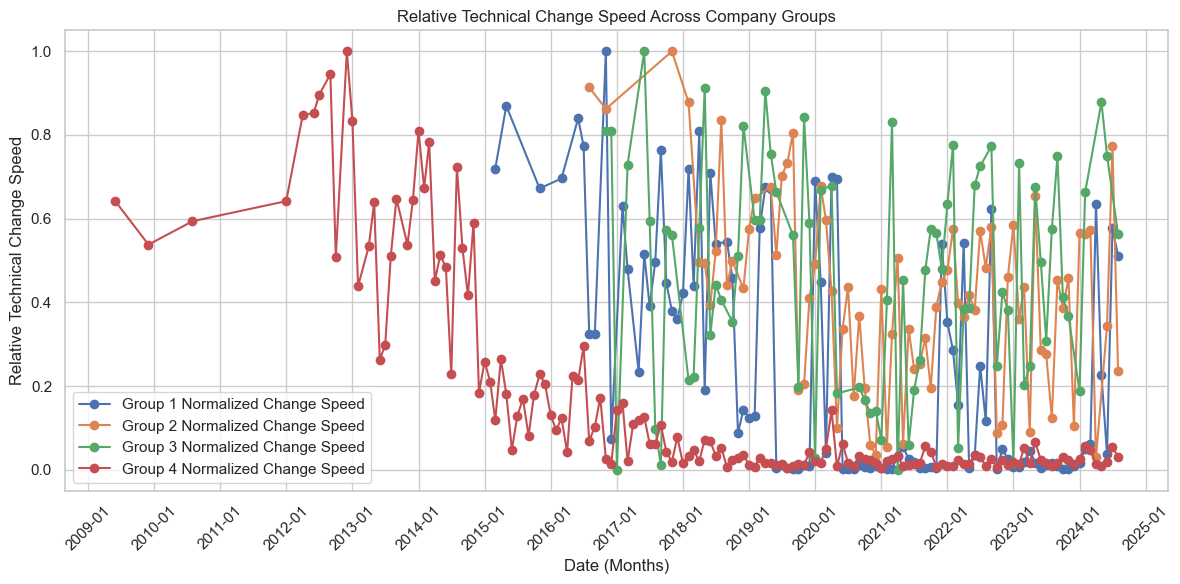

In [46]:
df_merged['text_data'] = df_merged['topic'] + ' ' + df_merged['subfield']
model = SentenceTransformer('all-MiniLM-L6-v2')
text_embeddings = model.encode(df_merged['text_data'].tolist())

combined_features = np.hstack([text_embeddings])
df_merged['embedding'] = list(combined_features)

df_merged['date'] = df_merged['date'].apply(lambda x: x.to_timestamp() if isinstance(x, pd.Period) else x)

grouped = df_merged.groupby(['company_group', 'date'])['embedding'].apply(lambda x: np.mean(np.vstack(x), axis=0))

def calculate_change_speed(vectors):
    cos_similarities = [cosine_similarity([vectors[i]], [vectors[i+1]])[0][0] for i in range(len(vectors) - 1)]
    change_speeds = [1 - sim for sim in cos_similarities]
    return change_speeds

change_speeds = {}
dates_dict = {}
for group, data in grouped.groupby(level=0):
    embeddings_over_time = data.values
    change_speeds[group] = calculate_change_speed(embeddings_over_time)
    dates_dict[group] = pd.to_datetime(data.index.get_level_values('date')[1:])

def relative_normalize(speeds):
    max_speed = max(speeds) if speeds else 1
    return [speed / max_speed for speed in speeds]

normalized_change_speeds = {group: relative_normalize(speeds) for group, speeds in change_speeds.items()}

plt.figure(figsize=(12, 6))
for group, speeds in normalized_change_speeds.items():
    dates = dates_dict[group]
    plt.plot(dates, speeds, label=f'{group} Normalized Change Speed', marker='o')

plt.xlabel('Date (Months)')
plt.ylabel('Relative Technical Change Speed')
plt.title('Relative Technical Change Speed Across Company Groups')

plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/0r/l5m4n5m135q717d1br283d280000gn/T/ipykernel_32436/1103306658.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['text_data'] = df_merged['topic'] + ' ' + df_merged['subfield']
/var/folders/0r/l5m4n5m135q717d1br283d280000gn/T/ipykernel_32436/1103306658.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['embedding'] = list(combined_features)
/var/folders/0r/l5m4n5m135q717d1br283d280000gn/T/ipykernel_32436/1103306658.py:17: SettingWithCopyWarning: 
A value is trying to be 

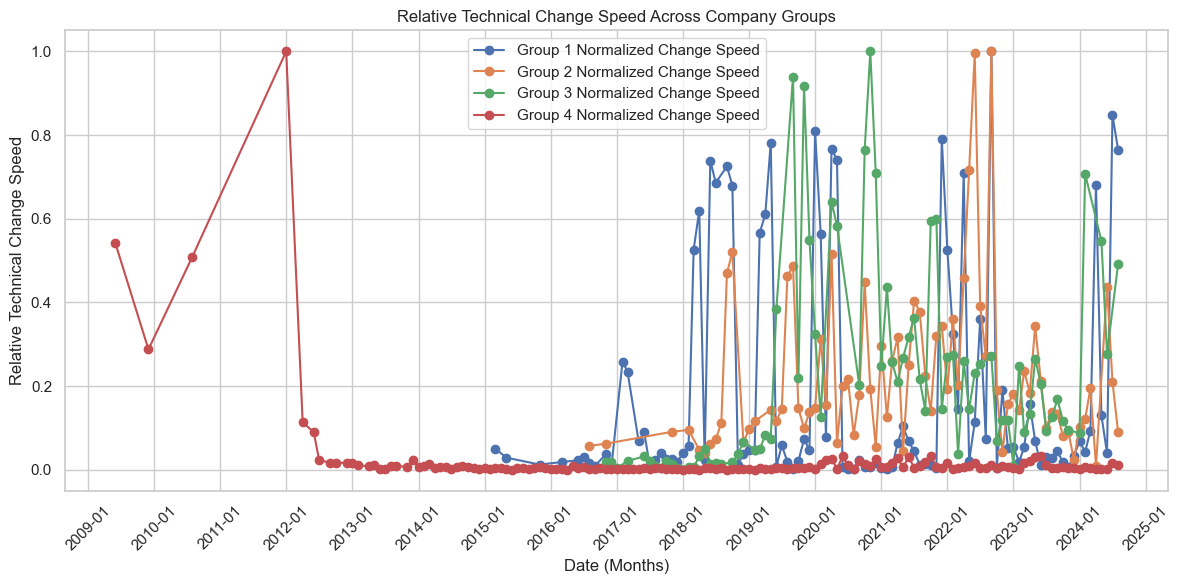

In [45]:
numerical_features = ['fs_m12', 'bs_m12', 'q_m12', 'fs_m24', 'bs_m24', 'q_m24']
df_merged = df_merged.dropna(subset=numerical_features)

scaler = StandardScaler()
scaled_numerical_features = scaler.fit_transform(df_merged[numerical_features])

df_merged['text_data'] = df_merged['topic'] + ' ' + df_merged['subfield']
model = SentenceTransformer('all-MiniLM-L6-v2')
text_embeddings = model.encode(df_merged['text_data'].tolist())

combined_features = np.hstack([scaled_numerical_features, text_embeddings])
df_merged['embedding'] = list(combined_features)

df_merged['date'] = df_merged['date'].apply(lambda x: x.to_timestamp() if isinstance(x, pd.Period) else x)

grouped = df_merged.groupby(['company_group', 'date'])['embedding'].apply(lambda x: np.mean(np.vstack(x), axis=0))

def calculate_change_speed(vectors):
    cos_similarities = [cosine_similarity([vectors[i]], [vectors[i+1]])[0][0] for i in range(len(vectors) - 1)]
    change_speeds = [1 - sim for sim in cos_similarities]
    return change_speeds

change_speeds = {}
dates_dict = {}
for group, data in grouped.groupby(level=0):
    embeddings_over_time = data.values
    change_speeds[group] = calculate_change_speed(embeddings_over_time)
    dates_dict[group] = pd.to_datetime(data.index.get_level_values('date')[1:])

def relative_normalize(speeds):
    max_speed = max(speeds) if speeds else 1
    return [speed / max_speed for speed in speeds]

normalized_change_speeds = {group: relative_normalize(speeds) for group, speeds in change_speeds.items()}

plt.figure(figsize=(12, 6))
for group, speeds in normalized_change_speeds.items():
    dates = dates_dict[group]
    plt.plot(dates, speeds, label=f'{group} Normalized Change Speed', marker='o')

plt.xlabel('Date (Months)')
plt.ylabel('Relative Technical Change Speed')
plt.title('Relative Technical Change Speed Across Company Groups')

plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()